In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from read_file import *
from indicators import *

## Procedure I

In [24]:
## Loading data
n = 200
p = 6
filename = f"./data/2KP200-TA-0.dat"

w=np.zeros(n,dtype=int) # poids des objets
v=np.zeros((n,p),dtype=int) # utilités des objets
W = readFile(filename,w,v)

# ====== On prend un sous-ensemble du problème ====
n = 50
p = 3
w = w[:n]
v = v[:n,:p]
W = w.sum()//2
print(w.shape, v.shape, W)

(50,) (50, 3) 13299


In [29]:
## Phase I: generate non-dominated solution with PLS
params = (n,p,v,w,W)
m = 20
verbose = True
NBMAX = 20

YND = PLS(m,params,NBMAX,verbose= False)
points = list(map(lambda x: x[1], YND))
points = np.array(points)
print(f'nombre de points non-dominés trouvés: {len(points)}')

nombre de points non-dominés trouvés: 272


In [32]:
# On sauvegarde les points dans l'espace des critères
file_output = './sol/I2dim.sol'
np.savetxt(file_output, points)
points = np.loadtxt(file_output)
points = points.astype(int)

## Procedure II

In [76]:
class Model():
    def __init__(self, dim, mode='EU'):
        self.dim = dim
        self.f_normalize = 0
        self.mode = mode
        
        # gurobi
        self.model = gp.Model()
        self.model.Params.LogToConsole = 0
        
        if mode == 'EU':
            self.init_eu_model()
        elif mode == 'OWA':
            self.init_owa_model()
        elif mode == 'Choquet':
            self.init_choquet_model()

    def CSS(self, X):
        PMR = self.compute_PMR(X)
        MR = np.max(PMR,1)
        i = np.argmin(MR)
        j = np.argmax(PMR[i])
        if self.f_normalize == 0: self.f_normalize = MR.max()
        return X[i],X[j], MR[i]/self.f_normalize

    def compute_PMR(self, X):
        return [[self.optimize(y,x) for y in X] for x in X]
    
    def optimize(self, a, b):
        if self.mode == 'EU': return self.optimize_eu(a, b)
        elif self.mode == 'OWA': return self.optimize_owa(a, b)
        elif self.model == 'Choquet': return self.optimize_choquet(a, b) 
        
    def update(self, a, b):
        if self.mode == 'EU': self.update_eu(a, b)
        elif self.mode == 'OWA': self.update_owa(a, b)
        elif self.model == 'Choquet': self.update_choquet(a, b) 
        self.model.update()
    
    # ====== EU aggregator ======
    def init_eu_model(self):
        m = self.model
        self.w = np.array([m.addVar() for _ in range(self.dim)])
        m.addConstr(sum(self.w) == 1)

    def update_eu(self, a,b):
        self.model.addConstr(sum((a-b)*self.w) >= 0)
        

    # Optimize with the OWA function
    def optimize_eu(self, a, b=None):
        if b is None: b = np.zeros(self.dim)
        a, b = np.asarray(a), np.asarray(b)
        self.model.setObjective(sum(self.w*(a-b)), GRB.MAXIMIZE)
        self.model.update()
        self.model.optimize()
        return self.model.ObjVal

    # ====== OWA aggregator ======
    def init_owa_model(self):
        m = self.model
        w = np.array([m.addVar() for _ in range(self.dim)])
        self.w = w
        for i in range(self.dim-1):
            m.addConstr(w[i]-w[i+1]>=0, f'c{i+1}')
        m.addConstr(sum(w) == 1)

    def update_owa(self, a,b):
        a, b = np.sort(a), np.sort(b)
        self.update_eu(a,b)

    # Optimize with the OWA function
    def optimize_owa(self, a, b=None):
        if b is None: b = np.zeros(self.dim)
        a.sort()
        b.sort()
        return self.optimize_eu(a,b)
    
    # ====== Choquet aggregator ======
    # we use formulation with mass function
    def init_choquet_model(self):
        m = self.model
        self.w = np.array([m.addVar() for _ in range((1<<self.dim))])
        for x in self.w: # May be useless ?
             m.addConstr(x >= 0)
        m.addConstr(sum(self.w) == 1)
        m.addConstr(w[0] == 0)

    def update_choquet(self, a,b):
        pass

    # Optimize with the Choquet function
    def optimize_choquet(self, a, b=None):
        if b is None: b = np.zeros(self.dim)
        a, b = self.compute_xbar(a), self.compute_xbar(b)
        self.model.setObjective(sum(self.w*(a-b)), GRB.MAXIMIZE)
        self.model.update()
        self.model.optimize()
        return self.model.ObjVal
    
    # compute xbar
    # xbar[B] = min {x|x in B}
    def compute_xbar(self, x):
        xbar = [0]*((1<<self.dim))
        xbar[0] = max(x)
        Lmask = [0]   
        for _ in range(self.dim):
            new_masks = set()
            for S in Lmask:
                for i in range(self.dim):
                    elt = 1 << i
                    # si objet i est déjà dans le x
                    if S & elt: continue
                    xbar[S|elt] = min(xbar[S],x[i])
                    print(bin(S|elt), bin(S)[2:], bin(elt)[2:])
                    new_masks.add(S|elt)
            Lmask = new_masks
        xbar[0] = 0
        return np.array(xbar)

In [53]:
# On génère les paramètres du décideur
# fonction OWA
p = points.shape[1]
alpha = np.random.dirichlet(np.ones(p),size=1)[0]
alpha.sort() # poids décroissante 
alpha = alpha[::-1]
print('alpha: ', np.around(alpha,3))

# Solution optimale pour le décideur
owa_value = [owa(y, alpha) for y in points]
opt = points[np.argmax(owa_value)]
opt

alpha:  [0.422 0.351 0.227]


array([18312, 19926, 20260])

regret = 0.07
iteration = 1 | regret = 0.02
[18312 19926 20260] [18893 18934 19552]
iteration = 2 | regret = 0.00
[18312 19926 20260] [18893 18934 19552]


Text(0, 0.5, 'minimax regret')

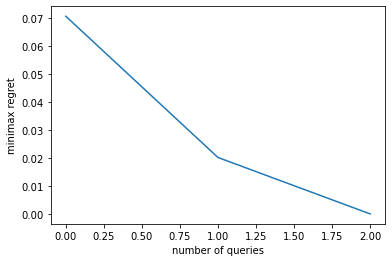

In [54]:
eps = 1e-4
model = Model(dim=p, mode='OWA')
function = owa

o1, o2, regret = model.CSS(points)
minmax_regrets = [regret]


print(f'{regret =: .2f}')
iteration = 1
while regret > eps:
    if np.array_equal(o1, o2): break
    if function(o1,alpha) >= function(o2, alpha): 
        model.update(o1,o2)
    else: 
        model.update(o2,o1)
    o1, o2, regret = model.CSS(points)
    minmax_regrets.append(regret)
    print(f'{iteration = } | {regret =: .2f}')
    print(o1, o2)
    iteration += 1
    
plt.plot(minmax_regrets)
plt.xlabel('number of queries')
plt.ylabel('minimax regret')